<a href="https://colab.research.google.com/github/chase-urasaki/HyTI_Jitter_Metrology/blob/main/3_12_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount Google drive
from google.colab import drive

#Navigate to directory
drive.mount('/content/drive');
#cd 'drive'/MyDrive/'Jitter Metrology'/'Clean Room Data'/3_2_data

Mounted at /content/drive


In [2]:
cd drive/MyDrive/'Jitter Metrology'/'Clean Room Data'/3_12_data

/content/drive/.shortcut-targets-by-id/1oOTCuLadXNs0Gh6zZHhxR42ClxA_yakd/Jitter Metrology/Clean Room Data/3_12_data


In [3]:
#Import essentials
import numpy as np 
import os 
from matplotlib import pyplot as plt 
from matplotlib import ticker 
import scipy.signal as sp
import sys
import pandas as pd

In [4]:
def seperate_data_from(data_array):
    xdata = data_array[:,-2]
    ydata = data_array[:,-1]
    vsum_data = data_array[:,-3]
    tdata = data_array[:,1]
    return xdata, ydata, vsum_data, tdata
    
def one_sided_fft(t,x):
    full_amplitude_spectrum = np.abs(np.fft.fft(x))/x.size
    full_freqs = np.fft.fftfreq(x.size, np.mean(np.ediff1d(t)))
    oneinds = np.where(full_freqs >=0.0)
    one_sided_freqs = full_freqs[oneinds]
    one_sided_amplitude_spectrum=2*full_amplitude_spectrum[oneinds]
    return one_sided_freqs, one_sided_amplitude_spectrum

def power_spectrum(t,x):
    onef, oneamps = one_sided_fft(t,x)
    return onef, oneamps**2

def lomb_scargle_pspec(t, x):
    tstep = np.mean(np.ediff1d(t))
    freqs = np.fft.fftfreq(x.size, tstep)
    idxx = np.argsort(freqs)
    one_sided_freqs = freqs[idxx]
    one_sided_freqs = one_sided_freqs[one_sided_freqs>0]
    #KLUDGE TO KEEP PERIODOGRAM FROM CRASHING
    one_sided_freqs = one_sided_freqs+0.00001*np.random.random(one_sided_freqs.size)
    #THE FOLLOWING LINE CRASHES WITHOUT THE KLUDGE
    pgram = sp.lombscargle(t, x, one_sided_freqs*2*np.pi)
    return one_sided_freqs, (pgram/(t.size/4))

In [5]:
platform1 = np.genfromtxt('data_3_12_platform_1in_20230312-132827.csv', delimiter = ',', skip_header = 2)
platform1_xdata, platform1_ydata, platform1_vsum, platform1_tdata = seperate_data_from(platform1)
platform2 = np.genfromtxt('data_3_12_platform_2in_20230312-133519.csv', delimiter = ',', skip_header = 2)
platform2_xdata, platform2_ydata, platform2_vsum, platform2_tdata = seperate_data_from(platform2)
platform3 = np.genfromtxt('data_3_12_platform_3in_20230312-134001.csv', delimiter = ',', skip_header = 2)
platform3_xdata, platform3_ydata, platform3_vsum, platform3_tdata = seperate_data_from(platform3)
platform4 = np.genfromtxt('data_3_12_platform_4in_20230312-134508.csv', delimiter = ',', skip_header = 2)
platform4_xdata, platform4_ydata, platform4_vsum, platform4_tdata = seperate_data_from(platform4)
platform5 = np.genfromtxt('data_3_12_platform_5in_20230312-135129.csv', delimiter = ',', skip_header = 2)
platform5_xdata, platform5_ydata, platform5_vsum, platform5_tdata = seperate_data_from(platform5)
platform6 = np.genfromtxt('data_3_12_platform_6in_20230312-135804.csv', delimiter = ',', skip_header = 2)
platform6_xdata, platform6_ydata, platform6_vsum, platform6_tdata = seperate_data_from(platform6)

In [6]:
platform1_xpsc = power_spectrum(platform1_tdata, platform1_xdata - np.mean(platform1_xdata))
platform1_ypsc = power_spectrum(platform1_tdata, platform1_ydata - np.mean(platform1_ydata))

In [7]:
def plot_FFT_and_pos(tdata, xdata, ydata, xpsc, ypsc, plot_title): 
  fig_x, (ax1, ax2) = plt.subplots(2,1, figsize =(15,7))
  fig_x.suptitle(str(plot_title)+' (x - dir)')
  fig_x.tight_layout(h_pad = 4.5)
  ax1.plot(xpsc[0], xpsc[1])
  ax1.set_title('FFT')
  ax1.set_xlabel('Frequency [Hz]')
  ax1.set_ylabel(r'Spectral Density [V$^2$/Hz]')
  ax2.scatter(tdata, (xdata - np.mean(xdata)) * 1e6, alpha = 0.5)
  ax2.set_title('Position on Sensor')
  ax2.set_xlabel('Time [s]')
  ax2.set_ylabel(r'Position [$\mu$m]')

  fig_y, (ax3, ax4) = plt.subplots(2,1, figsize = (15,7))
  fig_y.suptitle(str(plot_title) + ' (y - dir)') 
  fig_y.tight_layout(h_pad = 4.5)
  ax3.plot(ypsc[0], ypsc[1], c = 'C1')
  ax3.set_title('FFT')
  ax3.set_xlabel('Frequency [Hz]')
  ax3.set_ylabel(r'Spectral Density [V$^2$/Hz]')
  ax4.scatter(tdata, (ydata - np.mean(ydata)) * 1e6, marker = '.', alpha = 0.5, c = 'C1')
  ax4.set_title('Position on Sensor')
  ax4.set_xlabel('Time [s]')
  ax4.set_ylabel(r'Position [$\mu$m]')

  return fig_x, fig_y 

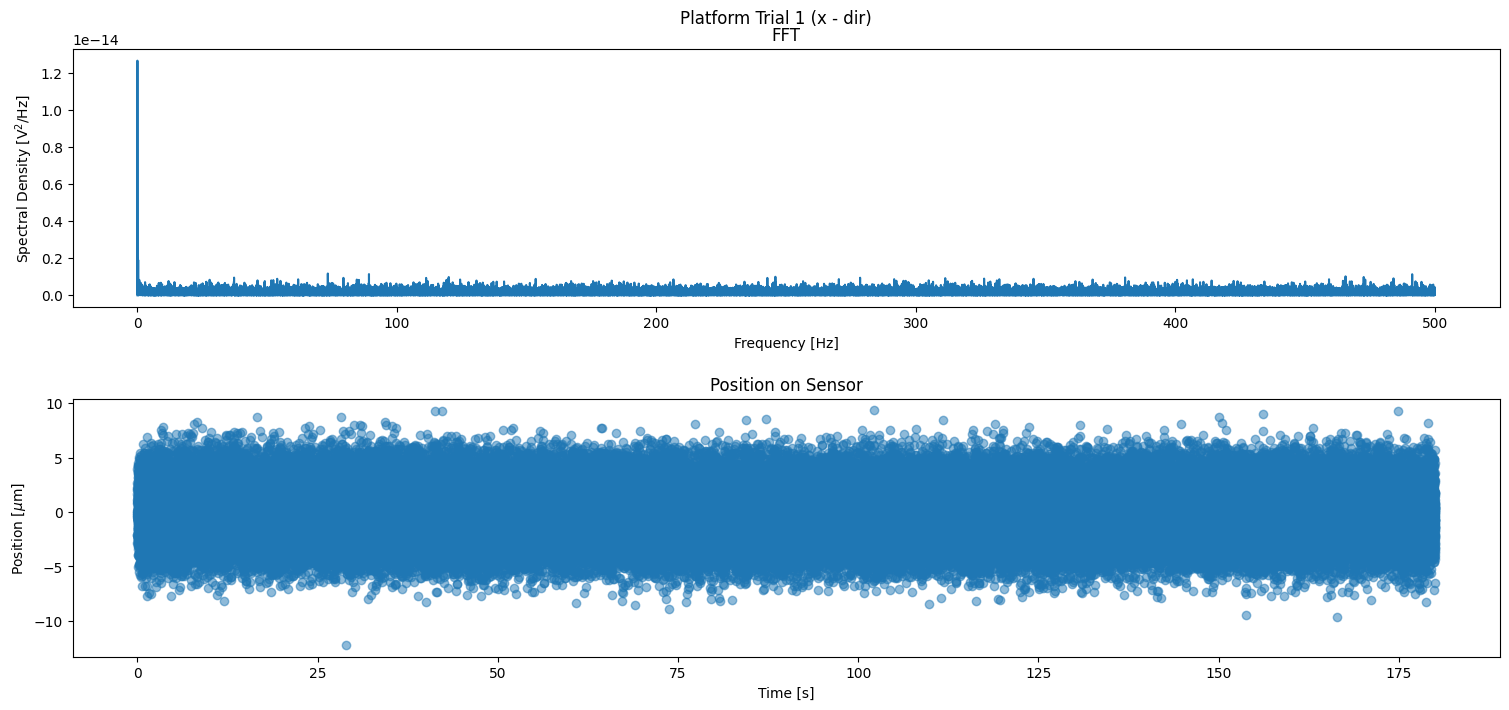

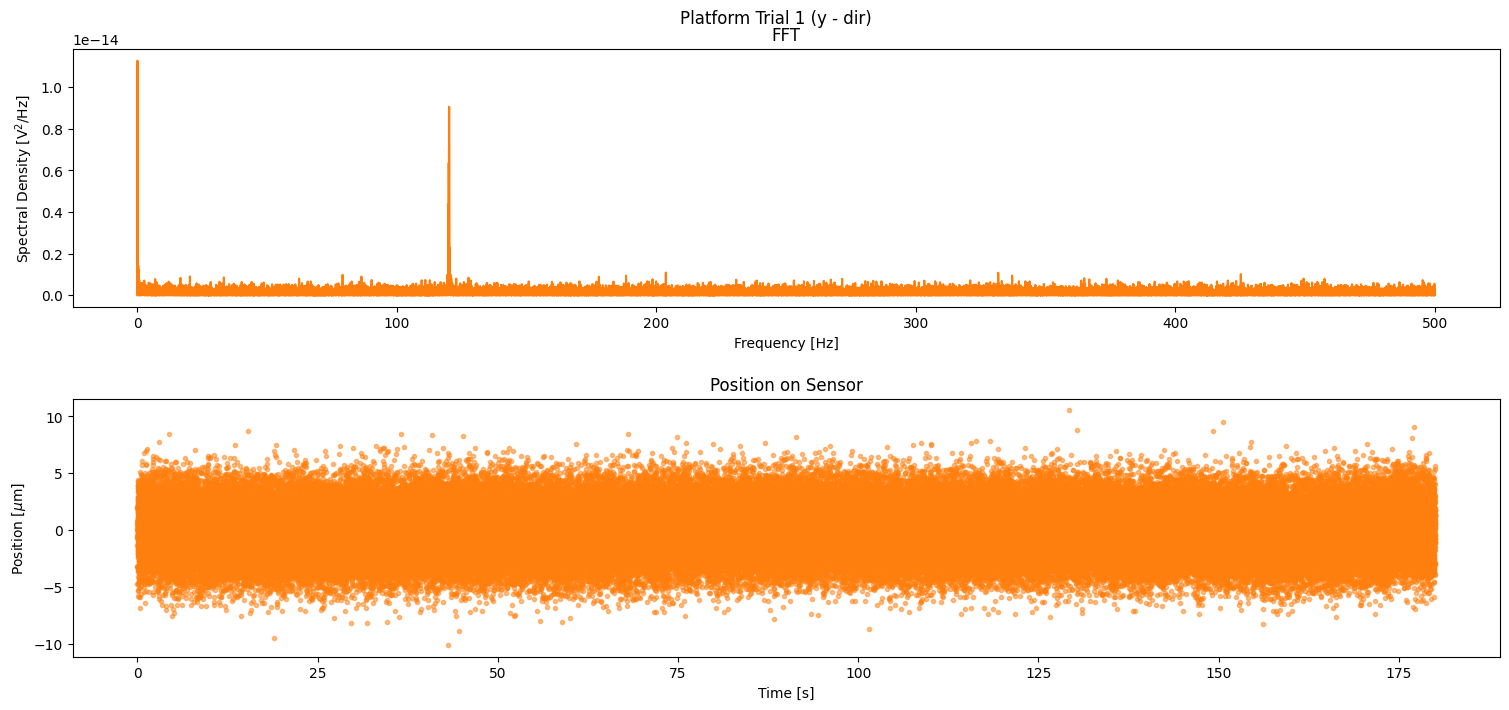

In [8]:
Platform1_plots = plot_FFT_and_pos(platform1_tdata, platform1_xdata, platform1_ydata, platform1_xpsc, platform1_ypsc, 'Platform Trial 1')

Interesting thing is the spike at 120 Hz in the y - direction. We'll see if this is repeated. 

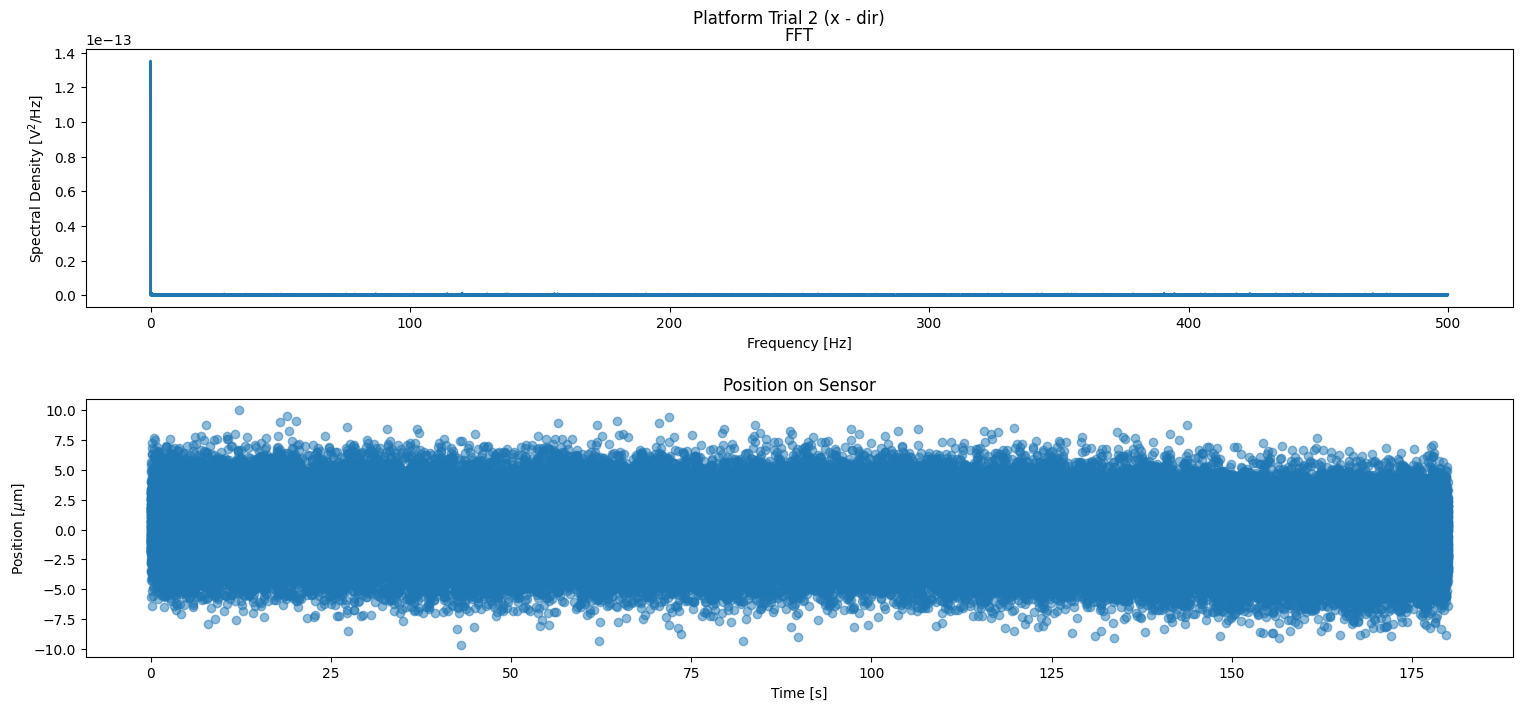

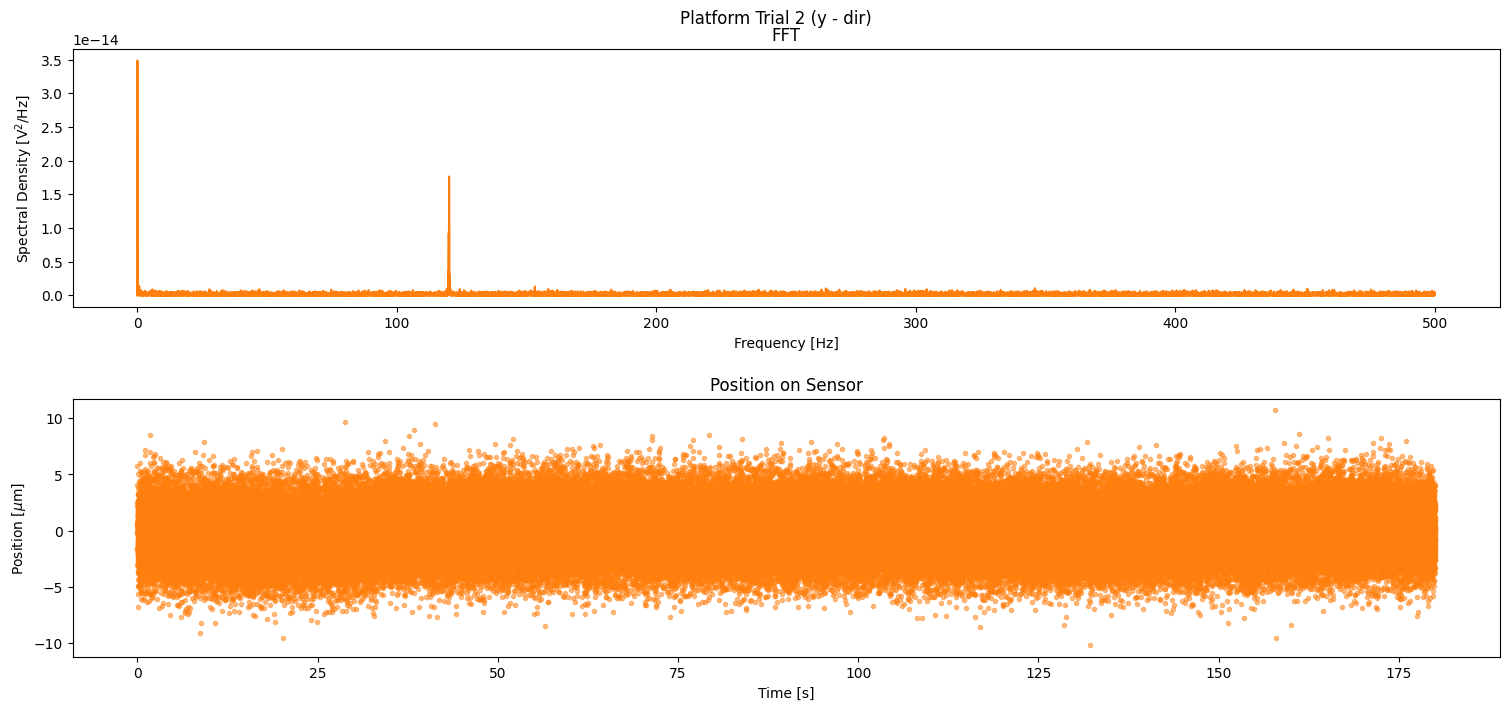

In [9]:
platform2_xpsc = power_spectrum(platform2_tdata, platform2_xdata - np.mean(platform2_xdata))
platform2_ypsc = power_spectrum(platform2_tdata, platform2_ydata - np.mean(platform2_ydata))

Platform2_plots = plot_FFT_and_pos(platform2_tdata, platform2_xdata, platform2_ydata, platform2_xpsc, platform2_ypsc, 'Platform Trial 2')

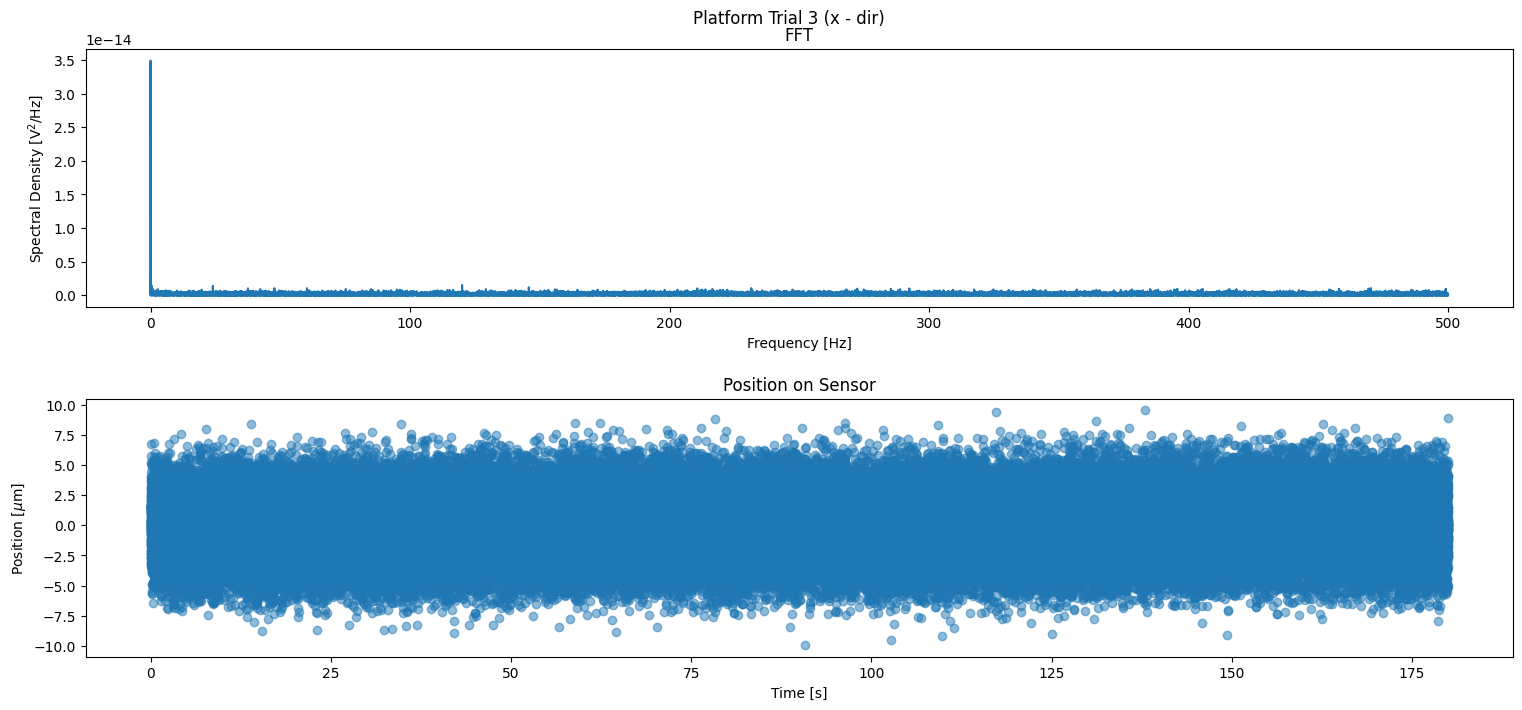

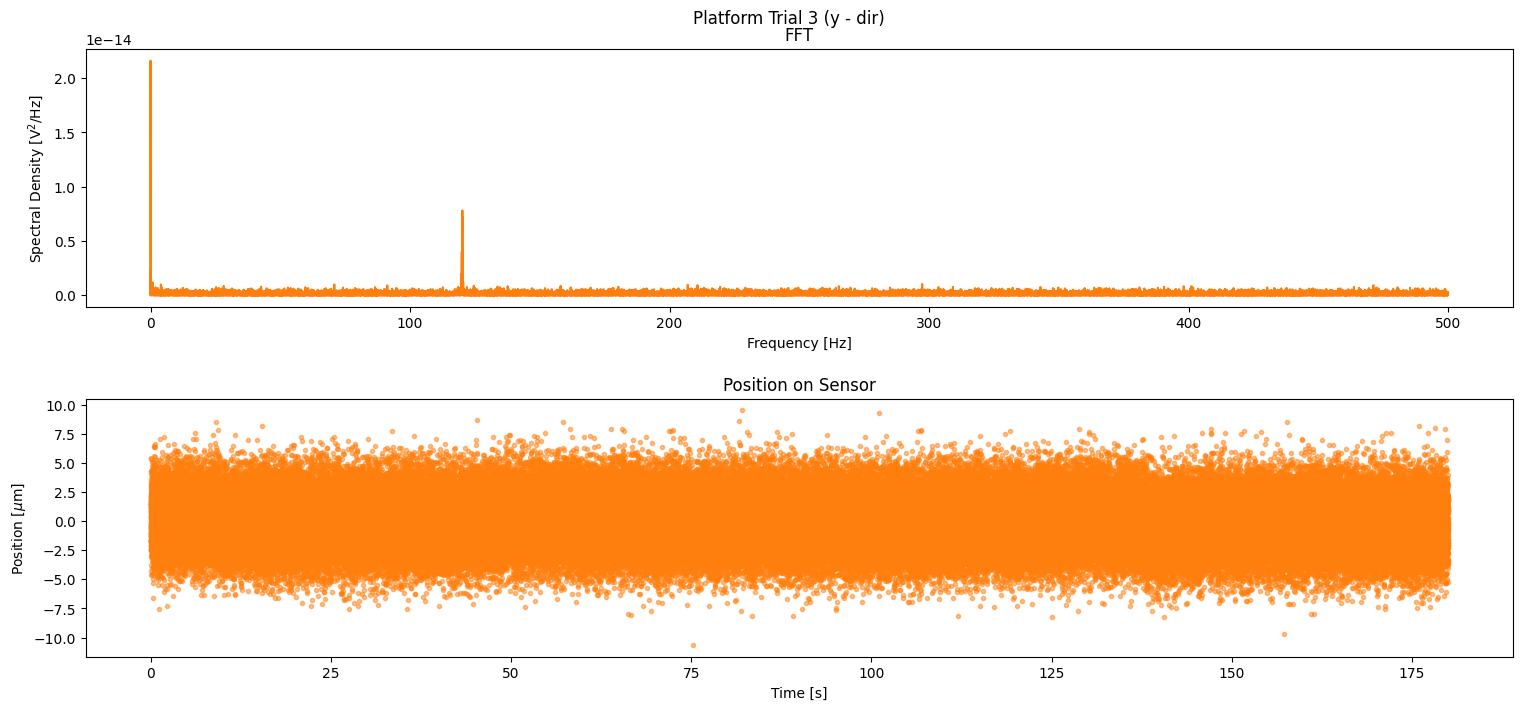

In [10]:
platform3_xpsc = power_spectrum(platform3_tdata, platform3_xdata - np.mean(platform3_xdata))
platform3_ypsc = power_spectrum(platform3_tdata, platform3_ydata - np.mean(platform3_ydata))

Platform3_plots = plot_FFT_and_pos(platform3_tdata, platform3_xdata, platform3_ydata, platform3_xpsc, platform3_ypsc, 'Platform Trial 3')

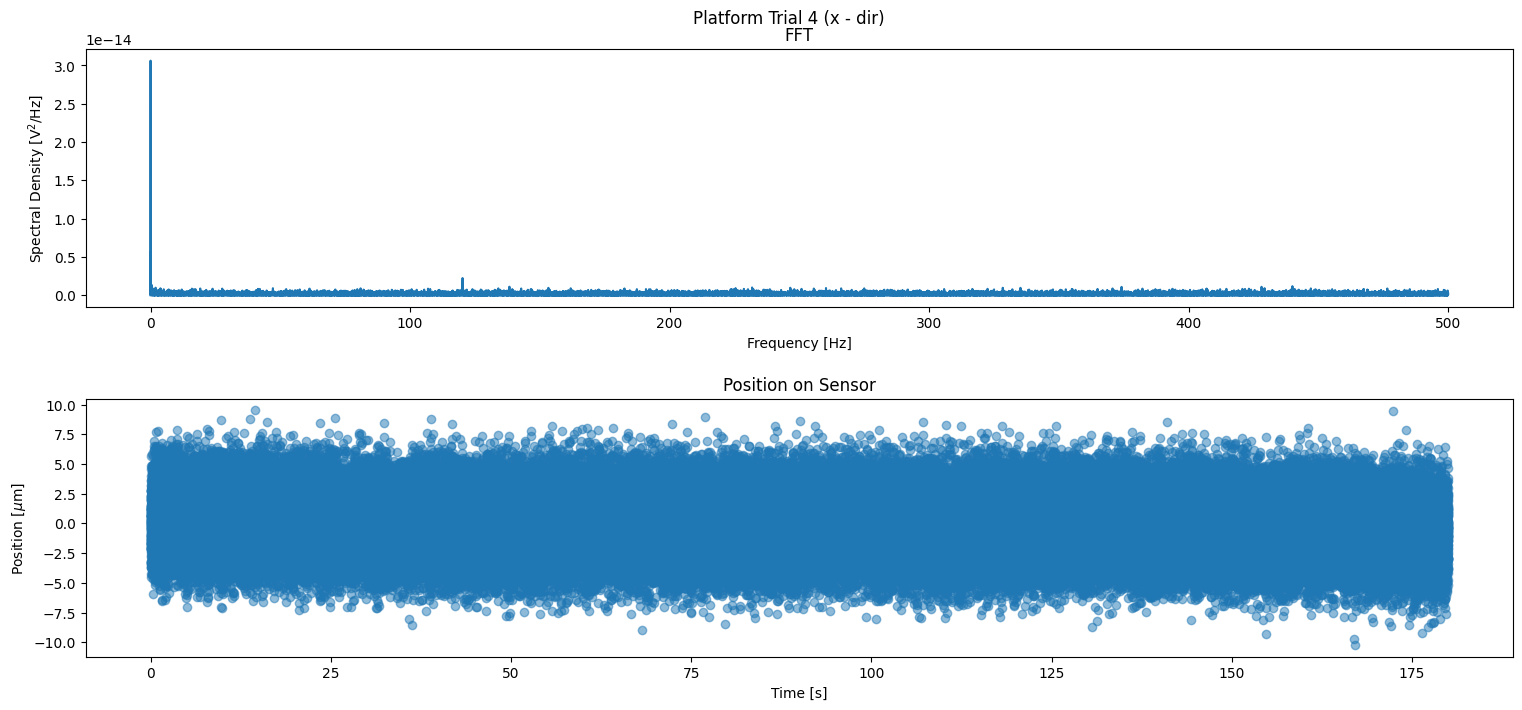

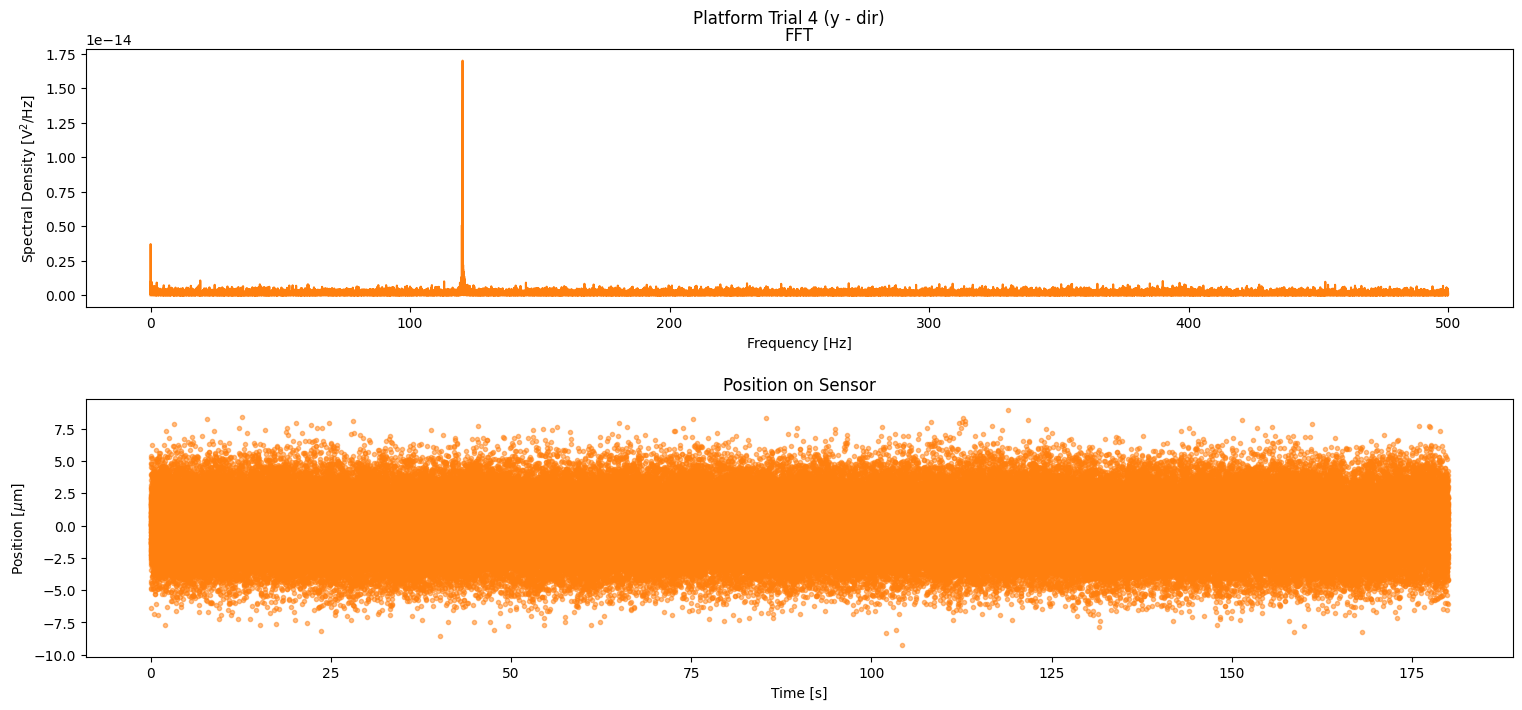

In [11]:
platform4_xpsc = power_spectrum(platform4_tdata, platform4_xdata - np.mean(platform4_xdata))
platform4_ypsc = power_spectrum(platform4_tdata, platform4_ydata - np.mean(platform4_ydata))

Platform4_plots = plot_FFT_and_pos(platform4_tdata, platform4_xdata, platform4_ydata, platform4_xpsc, platform4_ypsc, 'Platform Trial 4')

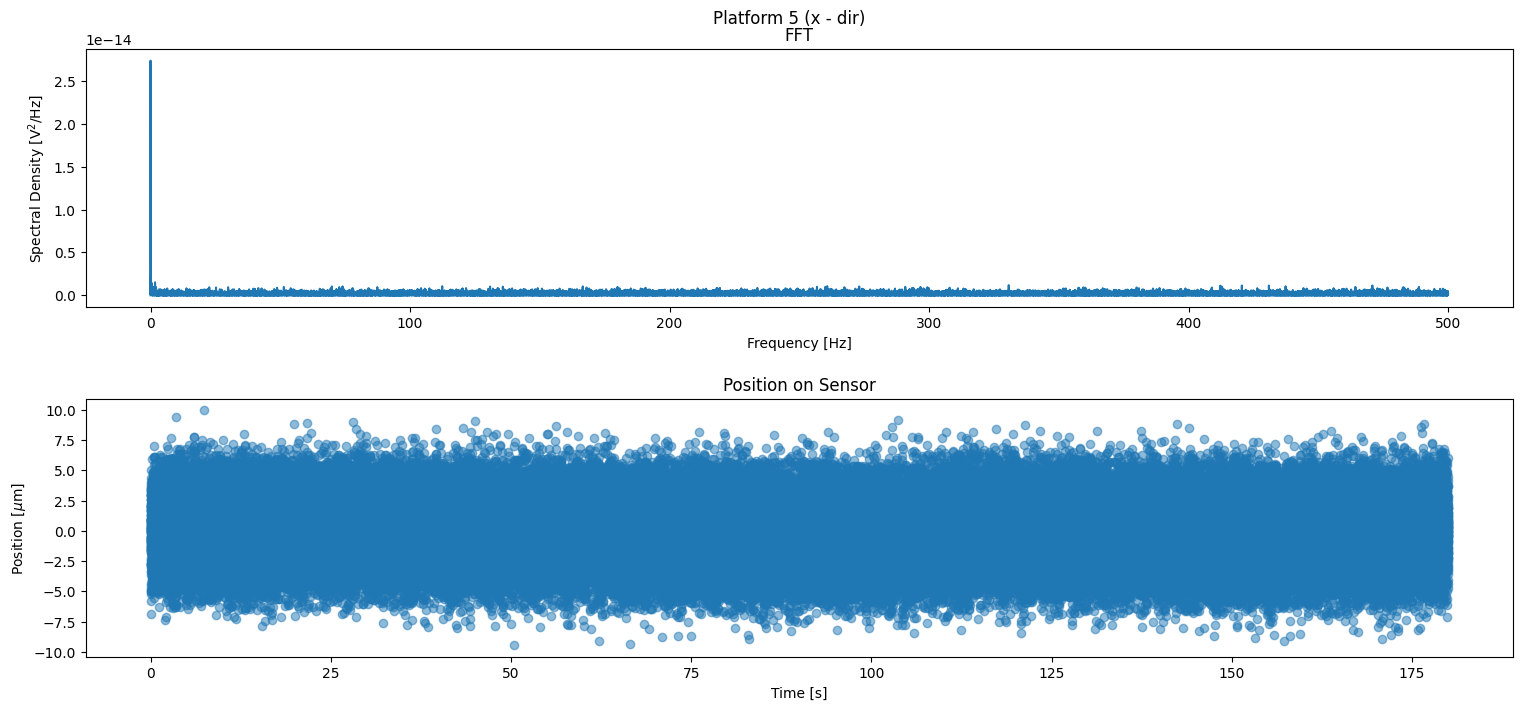

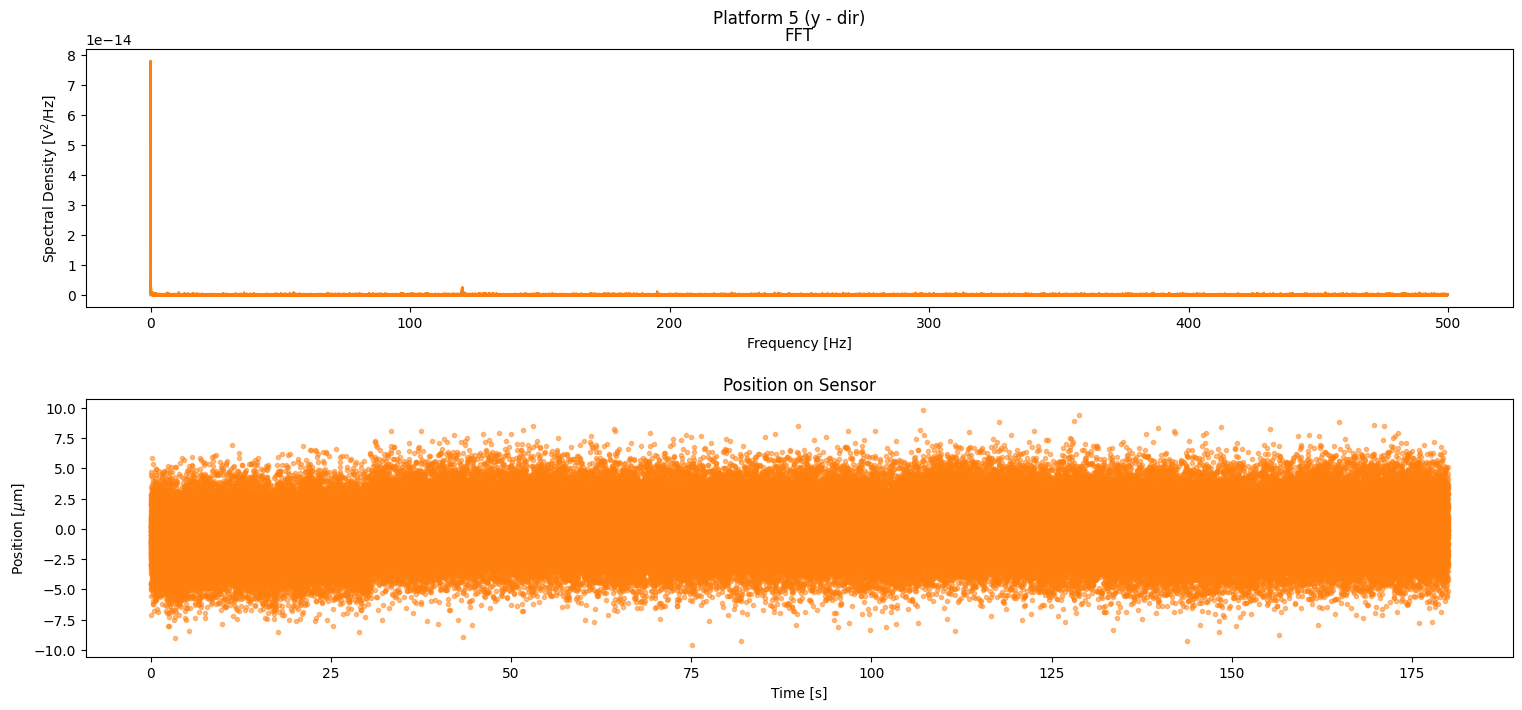

In [12]:
platform5_xpsc = power_spectrum(platform5_tdata, platform5_xdata - np.mean(platform5_xdata))
platform5_ypsc = power_spectrum(platform5_tdata, platform5_ydata - np.mean(platform5_ydata))

Platform5_plots = plot_FFT_and_pos(platform5_tdata, platform5_xdata, platform5_ydata, platform5_xpsc, platform5_ypsc, 'Platform 5')

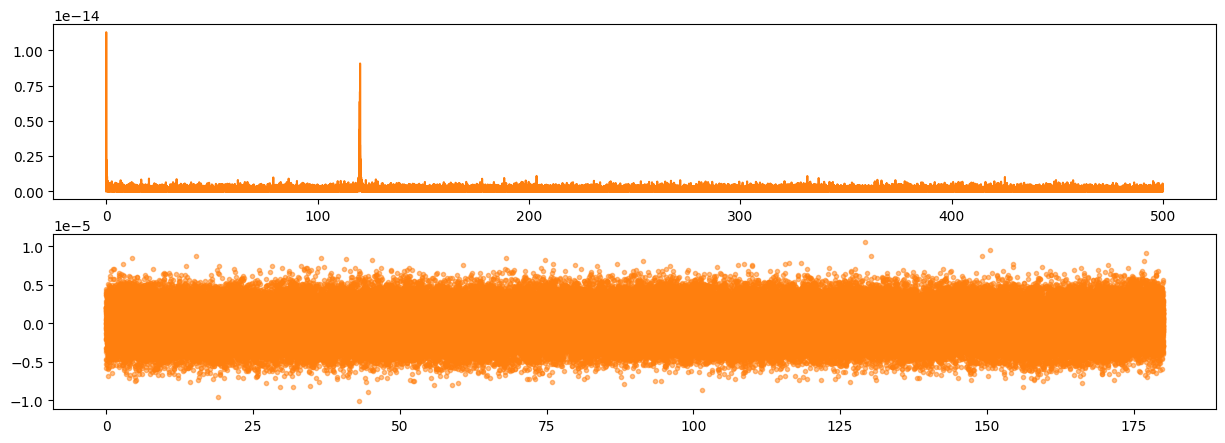

In [13]:
fig_platform1y, (ax5, ax6) = plt.subplots(2,1, figsize =(15,5))
ax5.plot(platform1_ypsc[0], platform1_ypsc[1], color = 'C1')
ax6.scatter(platform1_tdata, platform1_ydata - np.mean(platform1_ydata), marker = '.', alpha = 0.5, c = 'C1')

# Bearing off, Payload and Cryocooler on, ADCS off

In [ ]:
bearingoff_electronicson_10 = np.genfromtxt('data_3_12_bearingoff_electronicson_10in_20230312-142947.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_10

In [14]:
bearingoff_electronicson_11 = np.genfromtxt('data_3_12_bearingoff_electronicson_11in_20230312-143437.csv', delimiter = ',', skip_header = 2)
bearingoff_electronicson_11_xdata, bearingoff_electronicson_11_ydata, bearingoff_electronicson_11_vsum, bearingoff_electronicson_11_tdata = seperate_data_from(bearingoff_electronicson_11)

In [15]:
bearingoff_electronicson_11_xpsc = power_spectrum(bearingoff_electronicson_11_tdata, bearingoff_electronicson_11_xdata - np.mean(bearingoff_electronicson_11_xdata))
bearingoff_electronicson_11_ypsc = power_spectrum(bearingoff_electronicson_11_tdata, bearingoff_electronicson_11_ydata - np.mean(bearingoff_electronicson_11_ydata))

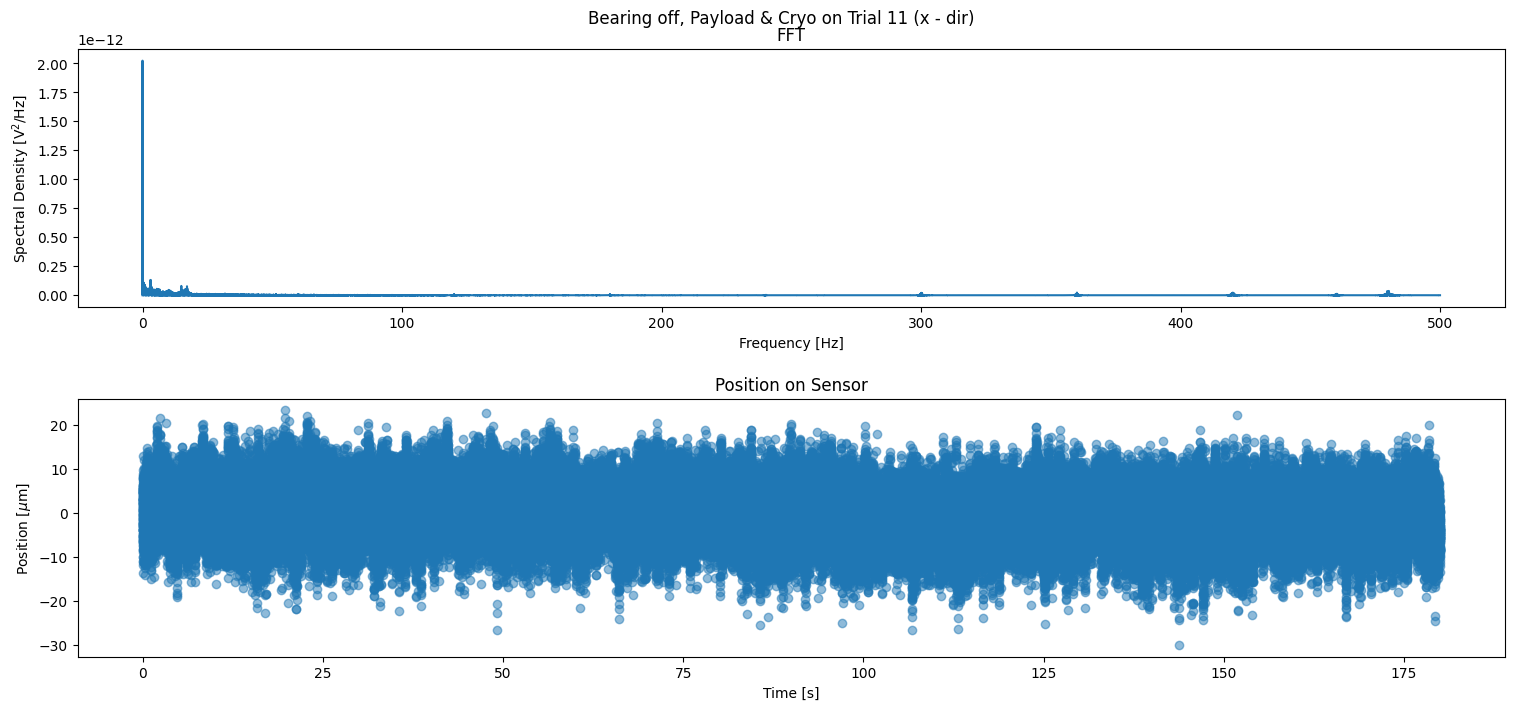

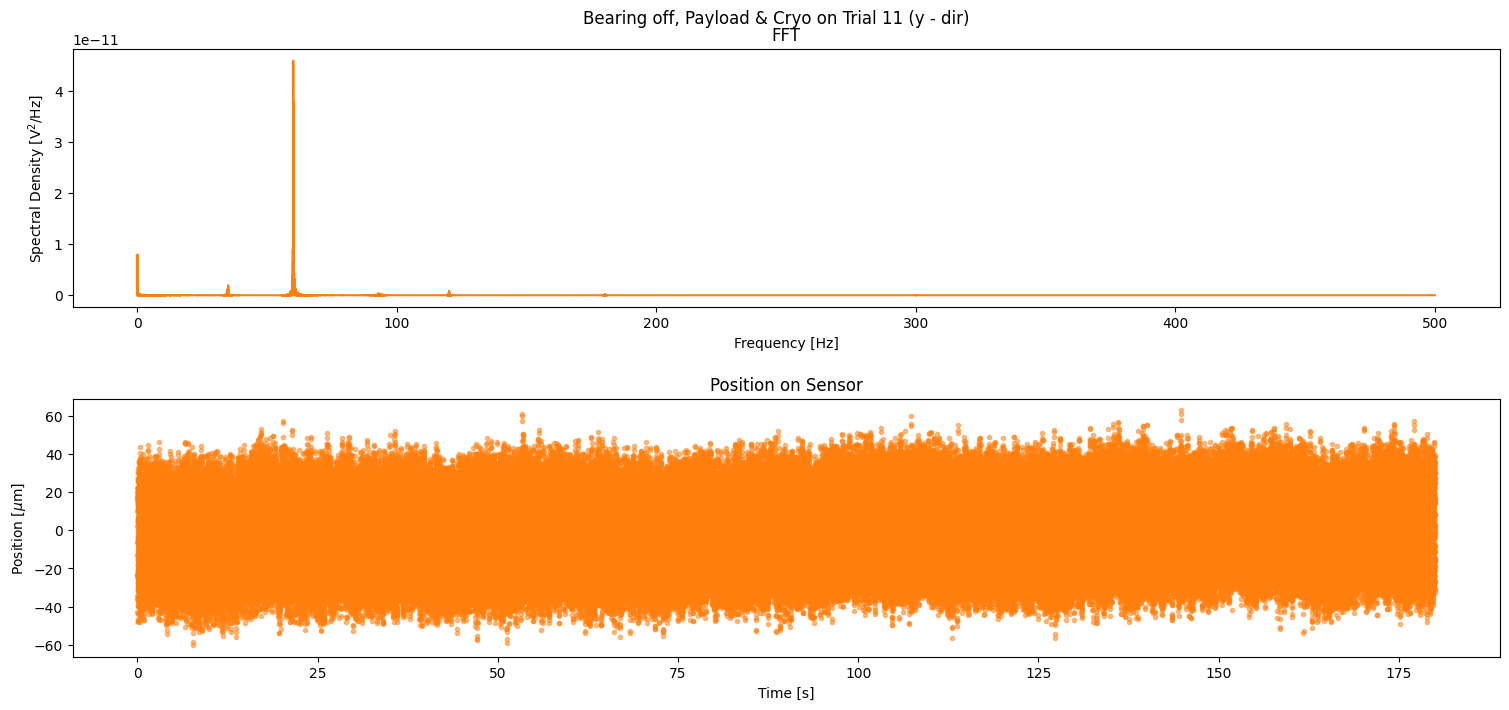

In [16]:
bearingoff_electronicson_11_plot = plot_FFT_and_pos(bearingoff_electronicson_11_tdata, bearingoff_electronicson_11_xdata, bearingoff_electronicson_11_ydata, bearingoff_electronicson_11_xpsc, bearingoff_electronicson_11_ypsc, 'Bearing off, Payload & Cryo on Trial 11')

ValueError: ignored

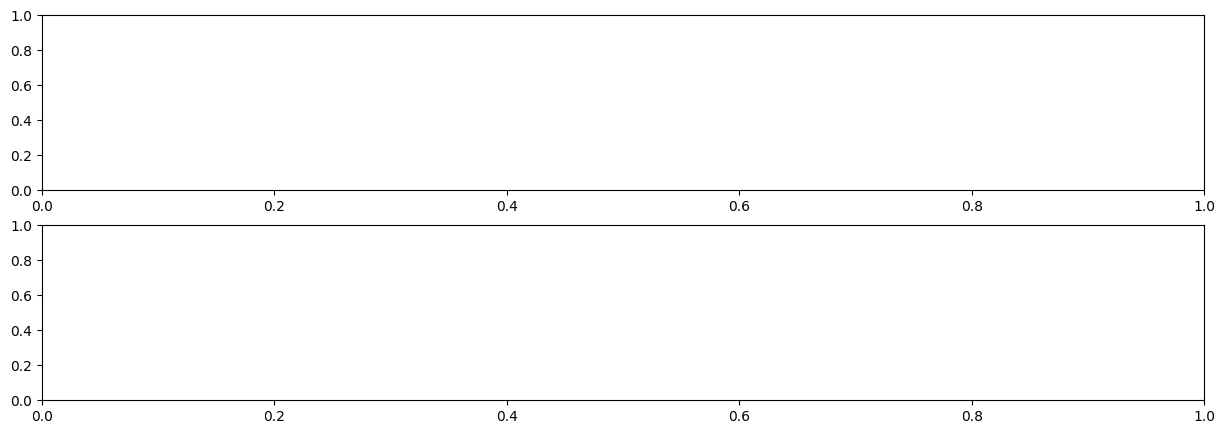

In [17]:
fig_bearingoff_electronicson_11y, (ax3, ax4) = plt.subplots(2,1, figsize = (15,5)) 
ax3.plot(bearingoff_electronicson_11_ypsc[0], bearingoff_electronicson_11_ypsc[1], c = )
ax4.plot(bearingoff_electronicson_11_tdata, bearingoff_electronicson_11_ydata - np.mean(bearingoff_electronicson_11_ydata))
#ax3.set_ylim(0, 1e-12)